In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras import Model
from tensorflow.keras.layers import (Conv1D , BatchNormalization, MaxPool1D,Flatten,
                                    Activation , Add, Input, concatenate, Dense,LSTM,
                                     Bidirectional , TimeDistributed)
from tensorflow.python.keras.utils.vis_utils import plot_model

In [2]:
# list of breath ids
def breath_ids(df):
    b = set()
    
    l = []
    b_id = df['breath_id']
    for i in b_id:
        b.add(i)
    for j in b:
        l.append(j)
    return l

# before u_out get opened
def prepared_data(df):
    a = df.groupby('breath_id')
    pressure = []
    input_air = []
    R = []
    C = []
    print('preparing the dataset ... ')
    for i in tqdm(breath_ids(df)):
        b = a.get_group(i)
        r = b['R'].values
        c = b['C'].values
        p = b['pressure'].values
        u_in = b['u_in'].values
        
        pressure.append(p)
        input_air.append(u_in)
        R.append(r[0])
        C.append(c[0])
    
    RR = np.expand_dims(R , axis = -1)
    CC = np.expand_dims(C , axis = -1)
    
    r_encoder = OneHotEncoder()
    r_1hot = r_encoder.fit_transform(RR)
    
    c_encoder = OneHotEncoder()
    c_1hot = c_encoder.fit_transform(CC)
    
    return (pad_sequences(input_air , dtype = 'float32'),
            r_1hot.toarray(),
            c_1hot.toarray(),
            pad_sequences(pressure , dtype = 'float32'))

In [3]:
train_df = pd.read_csv('../input/ventilator-pressure-prediction/train.csv')
train_df

,id,breath_id,R,C,time_step,u_in,u_out,pressure
0,1,1,20,50,0.000000,0.083334,0,5.837492
1,2,1,20,50,0.033652,18.383041,0,5.907794
2,3,1,20,50,0.067514,22.509278,0,7.876254
3,4,1,20,50,0.101542,22.808822,0,11.742872
4,5,1,20,50,0.135756,25.355850,0,12.234987
...,...,...,...,...,...,...,...,...
6035995,6035996,125749,50,10,2.504603,1.489714,1,3.869032
6035996,6035997,125749,50,10,2.537961,1.488497,1,3.869032
6035997,6035998,125749,50,10,2.571408,1.558978,1,3.798729
6035998,6035999,125749,50,10,2.604744,1.272663,1,4.079938


In [4]:
ins_df = train_df[train_df.u_out == 0]
ins_df

,id,breath_id,R,C,time_step,u_in,u_out,pressure
0,1,1,20,50,0.000000,0.083334,0,5.837492
1,2,1,20,50,0.033652,18.383041,0,5.907794
2,3,1,20,50,0.067514,22.509278,0,7.876254
3,4,1,20,50,0.101542,22.808822,0,11.742872
4,5,1,20,50,0.135756,25.355850,0,12.234987
...,...,...,...,...,...,...,...,...
6035945,6035946,125749,50,10,0.834147,1.869367,0,29.459013
6035946,6035947,125749,50,10,0.867574,2.154414,0,29.107502
6035947,6035948,125749,50,10,0.900917,1.304434,0,29.880825
6035948,6035949,125749,50,10,0.934309,1.733830,0,29.388710


In [5]:
u , r , c , p = prepared_data(ins_df)

preparing the dataset ... 


100%|██████████| 75450/75450 [00:26<00:00, 2839.85it/s]


In [6]:
uu = np.expand_dims(u , axis = -1)
pp = np.expand_dims(p , axis = -1)

print('shape p:',np.shape(pp))
print('shape u:',np.shape(uu))

shape p: (75450, 32, 1)
shape u: (75450, 32, 1)


In [7]:
n_train = 52815 #(80%)
n_valid = 7545 #(10%)
n_test = 15090 #(20%)

u_train = uu[:n_train]
u_valid = uu[n_train : n_train + n_valid]
u_test = uu[n_train + n_valid:n_train + n_valid + n_test]

p_train = pp[:n_train]
p_valid = pp[n_train : n_train + n_valid]
p_test = pp[n_train + n_valid:n_train + n_valid + n_test]

r_train = r[:n_train]
r_valid = r[n_train : n_train + n_valid]
r_test = r[n_train + n_valid:n_train + n_valid + n_test]

c_train = c[:n_train]
c_valid = c[n_train : n_train + n_valid]
c_test = c[n_train + n_valid:n_train + n_valid + n_test]

data = [u_train, u_valid, u_test, p_train, p_valid, p_test, r_train, r_valid, r_test,
       c_train, c_valid, c_test]
data_name = ['u_train', 'u_valid', 'u_test', 'p_train', 'p_valid', 'p_test', 'r_train', 'r_valid',
             'r_test', 'c_train', 'c_valid', 'c_test']
for k , v in enumerate(data):
    print(f'shape of',data_name[k]  ,f'is: {np.shape(v)}')
    print('____')

shape of u_train is: (52815, 32, 1)
____
shape of u_valid is: (7545, 32, 1)
____
shape of u_test is: (15090, 32, 1)
____
shape of p_train is: (52815, 32, 1)
____
shape of p_valid is: (7545, 32, 1)
____
shape of p_test is: (15090, 32, 1)
____
shape of r_train is: (52815, 3)
____
shape of r_valid is: (7545, 3)
____
shape of r_test is: (15090, 3)
____
shape of c_train is: (52815, 3)
____
shape of c_valid is: (7545, 3)
____
shape of c_test is: (15090, 3)
____


In [8]:
# LSTM Wide And Deep model

from tensorflow.keras.layers import LSTM , Bidirectional , Dense , TimeDistributed

def biLSTM_model():
    model = keras.models.Sequential([
    Bidirectional(LSTM(300,return_sequences=True,kernel_initializer='he_normal'),input_shape=(32 , 1)),
    Bidirectional(LSTM(200 ,return_sequences=True,kernel_initializer = 'he_normal')),
    Bidirectional(LSTM(100 ,return_sequences=True,kernel_initializer = 'he_normal')),
    tf.keras.layers.Dropout(0.2),
    TimeDistributed(Dense(32,activation = 'selu',kernel_initializer = 'he_normal'))    
])
    
    return model

def lstm_wide_and_deep():
    input_r = Input(shape=(3) , name='r_input')
    input_c = Input(shape=(3) , name='c_input')
    input_deep = Input(shape=(32,1) , name='deep_input')
    
    output_deep = biLSTM_model()(input_deep)
    flat = Flatten()(output_deep)
    concat = concatenate([input_r , input_c , flat])
    
    dens = Dense(32)(concat)
    
    model = Model(inputs=[input_r , input_c , input_deep] , outputs = dens)

    return model

In [9]:
model = lstm_wide_and_deep()
model.summary()

2022-10-17 12:15:39.019549: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-17 12:15:39.109733: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-17 12:15:39.110659: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-17 12:15:39.111753: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
deep_input (InputLayer)         [(None, 32, 1)]      0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 32, 32)       2413632     deep_input[0][0]                 
__________________________________________________________________________________________________
r_input (InputLayer)            [(None, 3)]          0                                            
__________________________________________________________________________________________________
c_input (InputLayer)            [(None, 3)]          0                                            
______________________________________________________________________________________________

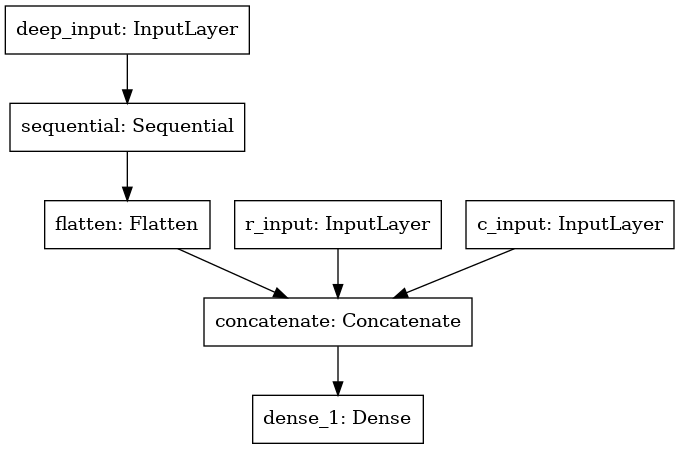

In [10]:
plot_model(model)

In [11]:
# naive model
naive_pred = []
for i in tqdm(p_test):
    pred = np.zeros(np.shape(i))
    pred[1:] = i[:31]
    naive_pred.append(pred)
    
naive_pred = np.asarray(naive_pred)
np.shape(naive_pred)

100%|██████████| 15090/15090 [00:00<00:00, 309410.32it/s]


(15090, 32, 1)

In [12]:
np.mean(keras.losses.mean_absolute_error(naive_pred , p_test))

1.4861554

loss =  1.502784013748169


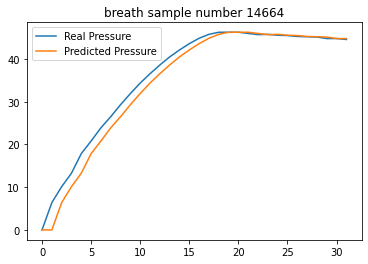

<Figure size 432x288 with 0 Axes>

In [13]:
for i in range(1):
    rnd_num = np.random.randint(n_test)
    print('loss = ' , np.mean(keras.losses.mean_absolute_error(p_test[rnd_num] , naive_pred[rnd_num])))
    plt.title(f'breath sample number {rnd_num}')
    plt.plot(p_test[rnd_num] , label = 'Real Pressure')
    plt.plot(naive_pred[rnd_num] , label = 'Predicted Pressure')
    plt.legend()
    plt.figure()
plt.show()

In [14]:
model = lstm_wide_and_deep()
model.compile(loss = 'mae' , optimizer='adam')
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='./ex.h5',
    monitor='val_loss',
    mode='min',
    save_best_only=True)

hist = model.fit([r_train , c_train , u_train],p_train,
                 validation_data =([r_valid , c_valid , u_valid],p_valid),
                 callbacks=[model_checkpoint_callback], epochs=300)

2022-10-17 12:15:48.456258: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/300


2022-10-17 12:15:55.698872: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


1651/1651 [==============================] - 44s 22ms/step - loss: 2.8785 - val_loss: 2.0529
Epoch 2/300
1651/1651 [==============================] - 34s 20ms/step - loss: 1.8722 - val_loss: 1.6600
Epoch 3/300
1651/1651 [==============================] - 34s 21ms/step - loss: 1.5559 - val_loss: 1.4275
Epoch 4/300
1651/1651 [==============================] - 34s 21ms/step - loss: 1.3970 - val_loss: 1.2843
Epoch 5/300
1651/1651 [==============================] - 34s 21ms/step - loss: 1.2830 - val_loss: 1.2637
Epoch 6/300
1651/1651 [==============================] - 34s 21ms/step - loss: 1.2004 - val_loss: 1.1814
Epoch 7/300
1651/1651 [==============================] - 34s 21ms/step - loss: 1.1412 - val_loss: 1.1096
Epoch 8/300
1651/1651 [==============================] - 35s 21ms/step - loss: 1.0856 - val_loss: 1.0628
Epoch 9/300
1651/1651 [==============================] - 35s 21ms/step - loss: 1.0368 - val_loss: 1.0074
Epoch 10/300
1651/1651 [==============================] - 35s 21ms/

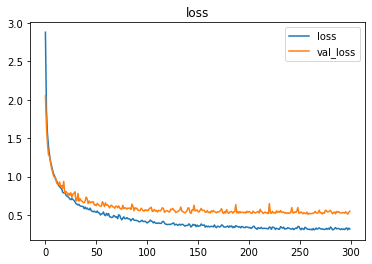

In [15]:
plt.title('loss')
plt.plot(range(len(hist.history['loss'])) , hist.history['loss'] , label = 'loss')
plt.plot(range(len(hist.history['loss'])) , hist.history['val_loss'] , label = 'val_loss')
plt.legend()
plt.show()

In [16]:
model.evaluate([r_valid , c_valid , u_valid] , p_valid)

236/236 [==============================] - 2s 8ms/step - loss: 0.5500


0.5500240921974182

In [17]:
predictions = model.evaluate([r_test, c_test , u_test] , p_test)

472/472 [==============================] - 4s 8ms/step - loss: 0.5405


In [18]:
predictions = model.predict([r_test, c_test , u_test])

In [19]:
final_p = np.expand_dims(predictions , axis = -1)

In [20]:
np.shape(final_p)

(15090, 32, 1)

In [21]:
np.mean(keras.losses.mean_absolute_error(final_p , p_test))

0.5405045

Naive loss =  11.052890419960022
Predicted loss =  0.3043685


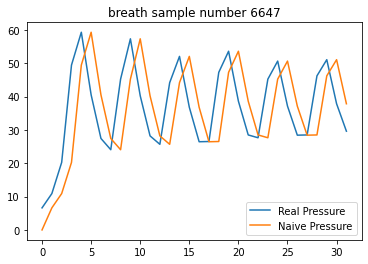

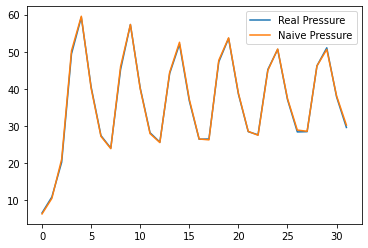

<Figure size 432x288 with 0 Axes>

In [22]:
for i in range(1):
    rnd_num = np.random.randint(n_test)
    print('Naive loss = ' , np.mean(keras.losses.mean_absolute_error(p_test[rnd_num] , naive_pred[rnd_num])))
    plt.title(f'breath sample number {rnd_num}')
    plt.plot(p_test[rnd_num] , label = 'Real Pressure')
    plt.plot(naive_pred[rnd_num] , label = 'Naive Pressure')
    plt.legend()
    plt.figure()
    print('Predicted loss = ' , np.mean(keras.losses.mean_absolute_error(p_test[rnd_num] , final_p[rnd_num])))
    plt.plot(p_test[rnd_num] , label = 'Real Pressure')
    plt.plot(final_p[rnd_num] , label = 'Naive Pressure')
    plt.legend()
    plt.figure()
plt.show()